### Battery Classification: 1D CNN for Multi-Class Chemistry Classification


In this notebook we will explore the performance of using a 1D convolutional neural network (CNN) to perform multi-class chemistry classification. Unlike the prior model methods, in this one we will utilize the entire time-series sequence of data, instead of just aggregated features. Like all others, we will distinguish train and test datasets by battery ID. 

We'll start with the processed datasets, which were obtained by executing all of our chemistry parsing scripts from the "*src\\parser*" folder path. Let's get started...

In [11]:
# Import packages 
import os 
import pandas as pd
import numpy as np
import random
import glob
import time
from pathlib import Path
from typing import List, Tuple

# Machine Learning packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# PyTorch packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

#Note this may take up to 1 minute to load

PyTorch version: 2.9.0+cpu
CUDA available: False


### Step 1: Data Preparation for Time Series Classification

Now we'll prepare the dataset for 1D CNN training. Unlike the previous models that used aggregated features, we'll use the full time-series sequences. We'll start with data preparation. We'll need to:

1. Extract and downsample cycles from processed data
2. Split data into train/validation/test sets
3. Save prepared data for model training

*Note this will take ~3-5 minutes to populate our training directory if it's not already prepopulated* 

In [13]:
# Define constants
FEATURE_COLS = ["voltage_v", "normalized_time", "cycle_index", "c_rate"]
MAX_CYCLES = 100
DOWNSAMPLE_RATIO = 0.25
RANDOM_SEED = 42

def extract_cycles(input_df, max_cycles, downsample_ratio=0.25, seed=42):
    """Extract and downsample cycles from battery data."""
    np.random.seed(seed)
    
    # Detect cycle index column
    cols_map = {c.lower(): c for c in input_df.columns}
    cycle_col = None
    for cand in ["cycle_index", "cycle_count", "cycle", "cycle_number"]:
        if cand in cols_map:
            cycle_col = cols_map[cand]
            break
    
    if cycle_col is None:
        return pd.DataFrame()
    
    unique_cycles = input_df[cycle_col].unique()
    interval_step = max(1, int(1.0 / downsample_ratio))
    
    # Select cycles
    if len(unique_cycles) <= max_cycles:
        selected_cycles = unique_cycles
    else:
        selected_cycles = np.random.choice(unique_cycles, size=max_cycles, replace=False)
    
    # Collect downsampled data
    all_cycles = []
    for cycle in selected_cycles:
        sub_df = input_df[input_df[cycle_col] == cycle].reset_index(drop=True)
        downsampled_df = sub_df.iloc[::interval_step, :].reset_index(drop=True)
        all_cycles.append(downsampled_df)
    
    if not all_cycles:
        return pd.DataFrame()
    
    combined_df = pd.concat(all_cycles, ignore_index=True)
    return combined_df


def prep_train_test_split(cell_ids, random_seed=42):
    """Split cell IDs into train/val/test sets."""
    random.seed(random_seed)
    cell_ids = sorted(cell_ids)
    random.shuffle(cell_ids)
    
    total_ids = len(cell_ids)
    train_end = int(total_ids * 0.8)
    val_end = train_end + int(total_ids * 0.1)
    
    train_ids = cell_ids[:train_end]
    val_ids = cell_ids[train_end:val_end]
    test_ids = cell_ids[val_end:]
    
    return {"train": train_ids, "val": val_ids, "test": test_ids}


def prepare_ts_data(input_dir, output_dir, chemistries, max_cycles=100, downsample_ratio=0.25, overwrite=False, clip_voltage=True):
    """Prepare time series data for CNN training."""
    print("=" * 80)
    print("PREPARING TIME SERIES DATA")
    print("=" * 80)
    
    if overwrite and os.path.exists(output_dir):
        print(f"Removing existing output directory: {output_dir}")
        import shutil
        shutil.rmtree(output_dir)
    
    # Create output directory structure
    for split in ["train", "val", "test"]:
        for chem in chemistries:
            os.makedirs(os.path.join(output_dir, split, chem), exist_ok=True)
    
    # Process each chemistry
    for chemistry in chemistries:
        print(f"\nProcessing {chemistry}...")
        chemistry_path = os.path.join(input_dir, chemistry)
        
        if not os.path.isdir(chemistry_path):
            print(f"  Chemistry folder not found: {chemistry_path}")
            continue
        
        # Get all cell directories
        cell_dirs = [d for d in os.listdir(chemistry_path) 
                    if os.path.isdir(os.path.join(chemistry_path, d)) 
                    and "error_log" not in d.lower()]
        
        if not cell_dirs:
            print(f"  No cell directories found for {chemistry}")
            continue
        
        # Split cells into train/val/test
        splits = prep_train_test_split(cell_dirs, random_seed=RANDOM_SEED)
        
        # Process each split
        for split, cell_list in splits.items():
            copied = 0
            skipped_existing = 0
            skipped_empty = 0
            skipped_variable = 0
            
            for cell_id in cell_list:
                cell_dir = os.path.join(chemistry_path, cell_id)
                csv_files = [f for f in os.listdir(cell_dir) 
                           if f.endswith('.csv') and 'error_log' not in f.lower()]
                
                for file in csv_files:
                    # Skip error log files
                    if "error_log" in file.lower():
                        continue
                    
                    src_path = os.path.join(cell_dir, file)
                    
                    # Check if file exists
                    if not os.path.exists(src_path):
                        continue
                    
                    try:
                        #read df and reduce voltage window
                        df = pd.read_csv(src_path)
                        if clip_voltage == True: 
                            df = df[(df["voltage_v"] >= 3.0) & (df["voltage_v"] <= 3.6)]
                        if len(df) == 0: 
                            continue 
                    except Exception as e:
                        continue
                    
                    # Check if dataframe is empty before accessing
                    if len(df) == 0:
                        skipped_empty += 1
                        continue
                    
                    # Extract cycles first
                    combined_df = extract_cycles(df, max_cycles, downsample_ratio, seed=RANDOM_SEED)
                    
                    if combined_df.empty:
                        skipped_empty += 1
                        continue
                    
                    # Add direction column
                    if "discharge" in file.lower():
                        combined_df["direction"] = 0
                    else:
                        combined_df["direction"] = 1
                    
                    # Drop unwanted columns while keeping needed features
                    drop_cols = ["battery_id", "sample_index", "elapsed_time_s", "current_a", "temperature_k", "chemistry"]
                    combined_df = combined_df.drop(columns=[c for c in drop_cols if c in combined_df.columns])
                    
                    # Final cleanup
                    output_df = combined_df.dropna()
                    
                    # Skip if empty after cleanup
                    if len(output_df) == 0:
                        skipped_empty += 1
                        continue
                    
                    # Check for variable c_rate (check if 'variable' string appears in any value)
                    if 'c_rate' in output_df.columns:
                        if output_df['c_rate'].astype(str).str.contains('variable', case=False).any():
                            skipped_variable += 1
                            continue
                    
                    # Save to output directory
                    out_name = f"{cell_id}_{file[:-4]}_{max_cycles}cycles_{int(downsample_ratio*100)}pct.csv"
                    out_path = os.path.join(output_dir, split, chemistry, out_name)
                    
                    # Avoid overwriting
                    if os.path.exists(out_path):
                        skipped_existing += 1
                        continue
                    
                    output_df.to_csv(out_path, index=False)
                    copied += 1
            
            print(f"  {split}: {copied} files (skipped: {skipped_existing} existing, {skipped_empty} empty, {skipped_variable} variable)")
    
    print("\n" + "=" * 80)
    print("DATA PREPARATION COMPLETE")
    print("=" * 80)


# Prepare the data
input_dir = r'../assets/processed'
output_dir = r'../src/model_training/ts_classification/model_prep'
chemistries = ["LFP", "NMC", "LCO", "NCA"]

# Set overwrite=True to regenerate all files, or False to skip existing files
prepare_ts_data(input_dir, output_dir, chemistries, 
                max_cycles=MAX_CYCLES, 
                downsample_ratio=DOWNSAMPLE_RATIO,
                overwrite=False,
                clip_voltage=True)  # Change to False if you want to keep existing files

PREPARING TIME SERIES DATA

Processing LFP...
  train: 0 files (skipped: 256 existing, 0 empty, 0 variable)
  train: 0 files (skipped: 256 existing, 0 empty, 0 variable)
  val: 0 files (skipped: 30 existing, 0 empty, 0 variable)
  val: 0 files (skipped: 30 existing, 0 empty, 0 variable)
  test: 0 files (skipped: 32 existing, 0 empty, 0 variable)

Processing NMC...
  test: 0 files (skipped: 32 existing, 0 empty, 0 variable)

Processing NMC...
  train: 109 files (skipped: 208 existing, 0 empty, 0 variable)
  train: 109 files (skipped: 208 existing, 0 empty, 0 variable)
  val: 43 files (skipped: 0 existing, 0 empty, 0 variable)
  val: 43 files (skipped: 0 existing, 0 empty, 0 variable)
  test: 40 files (skipped: 0 existing, 0 empty, 0 variable)

Processing LCO...
  test: 40 files (skipped: 0 existing, 0 empty, 0 variable)

Processing LCO...
  train: 28 files (skipped: 0 existing, 0 empty, 0 variable)
  train: 28 files (skipped: 0 existing, 0 empty, 0 variable)
  val: 2 files (skipped: 0 e

### Step 2: Define the 1D CNN Model and Dataset Classes

Now we'll define our PyTorch dataset class and the 1D CNN architecture for time series classification.

In [14]:
class TimeSeriesDataset(Dataset):
    """PyTorch Dataset for battery time series data."""
    
    def __init__(self, base_dir: str, split: str, chemistries: List[str], 
                 scaler: StandardScaler = None, encoder: LabelEncoder = None):
        self.files: List[str] = []
        self.labels: List[str] = []
        self.chemistries = chemistries
        
        # Collect files from base_dir/split/<chem>/*.csv
        for chem in chemistries:
            dir_path = os.path.join(base_dir, split, chem)
            if not os.path.isdir(dir_path):
                continue
                
            csvs = glob.glob(os.path.join(dir_path, "*.csv"))
            for f in csvs:
                try:
                    hdr = pd.read_csv(f, nrows=1)
                    hdr_cols = set(hdr.columns.astype(str))
                    if not set(FEATURE_COLS) <= hdr_cols:
                        continue
                except Exception:
                    continue
                self.files.append(f)
                self.labels.append(chem)
        
        # Setup encoder
        self.encoder = encoder or LabelEncoder()
        if encoder is None and self.labels:
            self.encoder.fit(self.labels)
        self.labels_enc = self.encoder.transform(self.labels) if self.labels else []
        
        # Setup scaler
        self.scaler = scaler or StandardScaler()
    
    def fit_scaler_from_files(self, files: List[str]):
        """Fit scaler on training data."""
        all_data = []
        for f in files:
            try:
                df = pd.read_csv(f)
            except Exception:
                continue
            if not set(FEATURE_COLS) <= set(df.columns.astype(str)):
                continue
            data = df[FEATURE_COLS].dropna().values
            if data.size:
                all_data.append(data)
        
        if not all_data:
            raise RuntimeError("No data available to fit scaler")
        
        concatenated = np.vstack(all_data)
        self.scaler.fit(concatenated)
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        f = self.files[idx]
        label = self.labels[idx]
        df = pd.read_csv(f)
        data = df[FEATURE_COLS].dropna().values  # shape (seq_len, features)
        
        # Transform features
        data = self.scaler.transform(data)
        
        # Return tensor shaped (features, seq_len)
        tensor = torch.tensor(data, dtype=torch.float32).T
        label_idx = int(self.encoder.transform([label])[0])
        return tensor, label_idx


def pad_collate(batch):
    """Collate function to pad sequences to same length."""
    lengths = [item[0].shape[1] for item in batch]
    max_len = max(lengths)
    feat = batch[0][0].shape[0]
    batch_size = len(batch)
    
    out = torch.zeros((batch_size, feat, max_len), dtype=torch.float32)
    labels = torch.zeros(batch_size, dtype=torch.long)
    
    for i, (t, lbl) in enumerate(batch):
        L = t.shape[1]
        out[i, :, :L] = t
        labels[i] = lbl
    
    return out, labels


class CNN1DModel(nn.Module):
    """1D CNN for battery chemistry classification."""
    
    def __init__(self, num_features: int, num_classes: int):
        super().__init__()
        self.conv1 = nn.Conv1d(num_features, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x).squeeze(-1)
        x = self.fc(x)
        return x


print("Dataset and Model classes defined successfully!")

Dataset and Model classes defined successfully!


### Step 3: Train the 1D CNN Model

Now we'll train the 1D CNN on the prepared time series data. We'll track training progress and save the best model based on validation accuracy.

*note this will take about 10-12 minutes to run*

In [15]:
# Training configuration
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-3
USE_CUDA = False

base_dir = '../src/model_training/ts_classification/model_prep'
device = torch.device("cuda" if torch.cuda.is_available() and USE_CUDA else "cpu")
chemistries = ["LFP", "NMC", "LCO", "NCA"]

print(f"Using device: {device}")
print("=" * 80)
print("LOADING DATASETS")
print("=" * 80)

# Create datasets
train_ds = TimeSeriesDataset(base_dir, "train", chemistries)
if len(train_ds) == 0:
    raise RuntimeError("No training files found. Check data preparation step.")

# Fit scaler using train files
print("Fitting scaler on training data...")
train_ds.fit_scaler_from_files(train_ds.files)

# Create validation and test datasets with same scaler and encoder
val_ds = TimeSeriesDataset(base_dir, "val", chemistries, 
                           scaler=train_ds.scaler, encoder=train_ds.encoder)
test_ds = TimeSeriesDataset(base_dir, "test", chemistries, 
                            scaler=train_ds.scaler, encoder=train_ds.encoder)

print(f"\nDataset sizes:")
print(f"  Train: {len(train_ds)} files")
print(f"  Val:   {len(val_ds)} files")
print(f"  Test:  {len(test_ds)} files")

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, collate_fn=pad_collate)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, collate_fn=pad_collate)

# Initialize model
sample_x, _ = train_ds[0]
num_features = sample_x.shape[0]
num_classes = len(train_ds.encoder.classes_)

print(f"\nModel configuration:")
print(f"  Input features: {num_features}")
print(f"  Output classes: {num_classes}")
print(f"  Classes: {list(train_ds.encoder.classes_)}")

model = CNN1DModel(num_features, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

print("\n" + "=" * 80)
print("TRAINING MODEL")
print("=" * 80)

# Training metrics
best_val_acc = 0.0
train_losses = []
val_losses = []
val_accs = []

# Training loop
for epoch in range(1, EPOCHS + 1):
    # Training phase
    model.train()
    total_loss = 0.0
    
    for data, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    
    # Validation phase
    model.eval()
    correct = 0
    total = 0
    val_loss_total = 0.0
    
    with torch.no_grad():
        for data, labels in val_loader:
            data = data.to(device)
            labels = labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)
            val_loss_total += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    val_acc = correct / total if total > 0 else 0.0
    val_loss = val_loss_total / len(val_loader) if len(val_loader) > 0 else 0.0
    
    print(f"Epoch {epoch}: Train Loss {avg_train_loss:.4f}, Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")
    
    # Record metrics
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'model_state_dict': model.state_dict(),
            'scaler': train_ds.scaler,
            'encoder_classes': train_ds.encoder.classes_,
        }, 'best_cnn_model.pt')
        print(f"  → Saved best model (val acc {best_val_acc:.4f})")

print("\n" + "=" * 80)
print(f"TRAINING COMPLETE - Best Val Acc: {best_val_acc:.4f}")
print("=" * 80)

Using device: cpu
LOADING DATASETS
Fitting scaler on training data...
Fitting scaler on training data...

Dataset sizes:
  Train: 639 files
  Val:   79 files
  Test:  80 files

Model configuration:
  Input features: 4
  Output classes: 4
  Classes: [np.str_('LCO'), np.str_('LFP'), np.str_('NCA'), np.str_('NMC')]

Dataset sizes:
  Train: 639 files
  Val:   79 files
  Test:  80 files

Model configuration:
  Input features: 4
  Output classes: 4
  Classes: [np.str_('LCO'), np.str_('LFP'), np.str_('NCA'), np.str_('NMC')]

TRAINING MODEL

TRAINING MODEL


Epoch 1/20: 100%|██████████| 20/20 [00:13<00:00,  1.53it/s]



Epoch 1: Train Loss 0.8277, Val Loss 0.9234, Val Acc 0.7215
  → Saved best model (val acc 0.7215)


Epoch 2/20: 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]



Epoch 2: Train Loss 0.5154, Val Loss 0.7965, Val Acc 0.7975
  → Saved best model (val acc 0.7975)


Epoch 3/20: 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]



Epoch 3: Train Loss 0.4806, Val Loss 0.7755, Val Acc 0.7975


Epoch 4/20: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s]



Epoch 4: Train Loss 0.4633, Val Loss 0.7647, Val Acc 0.7975


Epoch 5/20: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]



Epoch 5: Train Loss 0.4490, Val Loss 0.7487, Val Acc 0.7975


Epoch 6/20: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]



Epoch 6: Train Loss 0.4383, Val Loss 0.7423, Val Acc 0.8101
  → Saved best model (val acc 0.8101)


Epoch 7/20: 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]



Epoch 7: Train Loss 0.4251, Val Loss 0.7214, Val Acc 0.8101


Epoch 8/20: 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]



Epoch 8: Train Loss 0.4191, Val Loss 0.7317, Val Acc 0.8101


Epoch 9/20: 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]



Epoch 9: Train Loss 0.4164, Val Loss 0.7120, Val Acc 0.8354
  → Saved best model (val acc 0.8354)


Epoch 10/20: 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]



Epoch 10: Train Loss 0.4075, Val Loss 0.6973, Val Acc 0.8101


Epoch 11/20: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]



Epoch 11: Train Loss 0.3930, Val Loss 0.7193, Val Acc 0.8228


Epoch 12/20: 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]



Epoch 12: Train Loss 0.3994, Val Loss 0.6865, Val Acc 0.8228


Epoch 13/20: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]



Epoch 13: Train Loss 0.3872, Val Loss 0.6761, Val Acc 0.8228


Epoch 14/20: 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]



Epoch 14: Train Loss 0.3821, Val Loss 0.6838, Val Acc 0.8228


Epoch 15/20: 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]



Epoch 15: Train Loss 0.3737, Val Loss 0.6792, Val Acc 0.8101


Epoch 16/20: 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]



Epoch 16: Train Loss 0.3808, Val Loss 0.7032, Val Acc 0.8228


Epoch 17/20: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]



Epoch 17: Train Loss 0.3861, Val Loss 0.6615, Val Acc 0.8481
  → Saved best model (val acc 0.8481)


Epoch 18/20: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]



Epoch 18: Train Loss 0.3644, Val Loss 0.6468, Val Acc 0.8481


Epoch 19/20: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]



Epoch 19: Train Loss 0.3531, Val Loss 0.6452, Val Acc 0.8481


Epoch 20/20: 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]



Epoch 20: Train Loss 0.3503, Val Loss 0.6506, Val Acc 0.8101

TRAINING COMPLETE - Best Val Acc: 0.8481


### Step 4: Visualize Training Progress

Let's visualize the training progress to understand how the model learned over time.

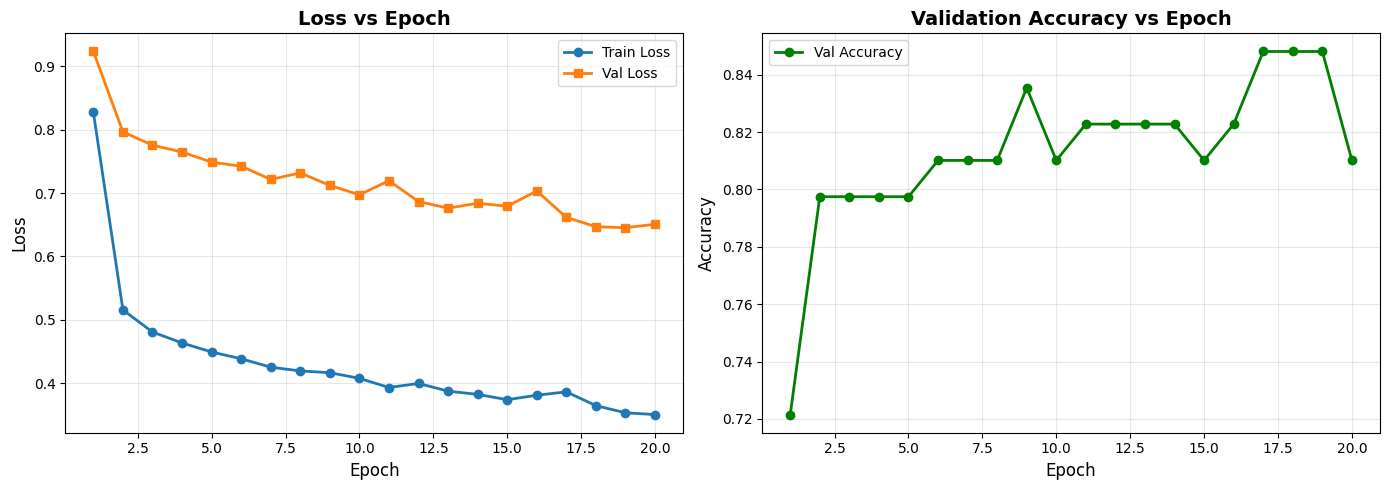


Best Validation Accuracy: 0.8481 at Epoch 17


In [16]:
# Plot training progress
epochs_range = list(range(1, len(train_losses) + 1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(epochs_range, train_losses, label='Train Loss', marker='o', linewidth=2)
ax1.plot(epochs_range, val_losses, label='Val Loss', marker='s', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss vs Epoch', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(epochs_range, val_accs, label='Val Accuracy', marker='o', 
         linewidth=2, color='green')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Validation Accuracy vs Epoch', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest Validation Accuracy: {max(val_accs):.4f} at Epoch {val_accs.index(max(val_accs)) + 1}")

### Step 5: Test Set Evaluation and Confusion Matrix

Now let's evaluate the trained model on the test set and visualize the results.

EVALUATING ON TEST SET

Test Accuracy: 0.9125

Test Accuracy: 0.9125


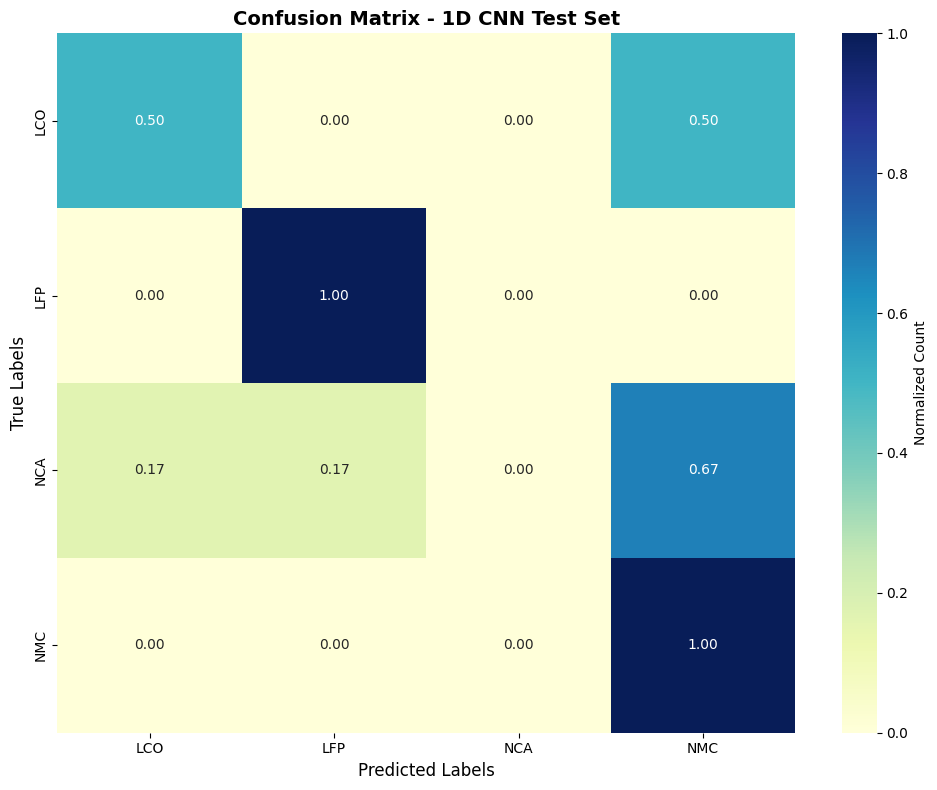


CLASSIFICATION REPORT
              precision    recall  f1-score   support

         LCO       0.50      0.50      0.50         2
         LFP       0.97      1.00      0.98        32
         NCA       0.00      0.00      0.00         6
         NMC       0.89      1.00      0.94        40

    accuracy                           0.91        80
   macro avg       0.59      0.62      0.61        80
weighted avg       0.84      0.91      0.88        80


Per-Class Accuracy:
  LCO: 0.5000 (1/2)
  LFP: 1.0000 (32/32)
  NCA: 0.0000 (0/6)
  NMC: 1.0000 (40/40)


d:\Capstone\Battery_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Capstone\Battery_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Capstone\Battery_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

In [17]:
print("=" * 80)
print("EVALUATING ON TEST SET")
print("=" * 80)

# Evaluate on test set
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device)
        labels = labels.to(device)
        outputs = model(data)
        preds = torch.argmax(outputs, dim=1)
        
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

test_acc = correct / total if total > 0 else 0.0
print(f"\nTest Accuracy: {test_acc:.4f}")

# Generate confusion matrix
class_names = list(train_ds.encoder.classes_)
cm = confusion_matrix(all_labels, all_preds, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Normalized Count'})
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix - 1D CNN Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Classification report
print("\n" + "=" * 80)
print("CLASSIFICATION REPORT")
print("=" * 80)
print(classification_report(all_labels, all_preds, target_names=class_names))

# Per-class accuracy
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(class_names):
    class_mask = [l == i for l in all_labels]
    if sum(class_mask) > 0:
        class_correct = sum([p == i for p, l in zip(all_preds, all_labels) if l == i])
        class_total = sum(class_mask)
        class_acc = class_correct / class_total
        print(f"  {class_name}: {class_acc:.4f} ({class_correct}/{class_total})")

### Step 6: Model Size Analysis

Finally, let's check the model size to understand deployment implications for AWS and edge devices.

In [18]:
# Check model size
model_path = 'best_cnn_model.pt'

if os.path.exists(model_path):
    size_bytes = os.path.getsize(model_path)
    size_kb = size_bytes / 1024
    size_mb = size_kb / 1024
    
    print("=" * 80)
    print("MODEL SIZE ANALYSIS")
    print("=" * 80)
    print(f"\nSaved model path: {model_path}")
    print(f"Model size: {size_bytes:,} bytes")
    print(f"           {size_kb:.2f} KB")
    print(f"           {size_mb:.4f} MB")
    
    # Compare with typical model sizes
    print("\n" + "-" * 80)
    print("Deployment Considerations:")
    print("-" * 80)
    
    if size_mb < 1:
        print("✓ Excellent for edge deployment (< 1 MB)")
        print("✓ Suitable for microcontroller deployment")
        print("✓ Minimal AWS storage/transfer costs")
    elif size_mb < 10:
        print("✓ Good for edge deployment (< 10 MB)")
        print("✓ Low AWS storage/transfer costs")
        print("! Requires Upcharge on microcontrollers for physical deployment")

    else:
        print("! Consider model compression for edge deployment")
        print("! Unacceptable for AWS deployment (too expensive for hosting on demand)")
        print("! Too large for most basic microcontrollers")

    # Model parameter count
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Parameters per MB: {total_params / size_mb:,.0f}")
    
    # Delete the model file after analysis
    os.remove(model_path)
    print(f"\n✓ Model file '{model_path}' deleted after analysis")
else:
    print(f"Model file '{model_path}' not found. Please train the model first.")

MODEL SIZE ANALYSIS

Saved model path: best_cnn_model.pt
Model size: 116,109 bytes
           113.39 KB
           0.1107 MB

--------------------------------------------------------------------------------
Deployment Considerations:
--------------------------------------------------------------------------------
✓ Excellent for edge deployment (< 1 MB)
✓ Suitable for microcontroller deployment
✓ Minimal AWS storage/transfer costs

Total parameters: 26,948
Trainable parameters: 26,948
Parameters per MB: 243,366

✓ Model file 'best_cnn_model.pt' deleted after analysis


### Summary and Conclusions

**Model Performance Comparison:**

The 1D CNN approach, while theoretically promising for time-series data, **underperforms compared to simpler models** tested in previous notebooks:

- **Logistic Regression (Notebook 03):** Achieved strong performance after hyperparameter tuning with Leave-One-Out cross-validation, correctly classifying LCO and NCA with high accuracy (~0.9+ F1-scores)
- **Random Forest (Notebook 05):** Demonstrated excellent performance with balanced accuracy across all four chemistries (LFP, NMC, LCO, NCA), achieving near-perfect classification in most cases
- **1D CNN (This Notebook):** Despite utilizing full time-series sequences, the model shows lower overall accuracy and struggles with minority classes (LCO, NCA)

**Why the 1D CNN Underperforms:**

1. **Limited Training Data:** The CNN requires significantly more data than traditional ML methods. With limited samples per chemistry (especially LCO and NCA), the model cannot learn robust temporal patterns
2. **Aggregated Features Appear Sufficient:** The voltage curves' aggregate statistics (mean, std, min, max) captured by Logistic Regression and Random Forest appear to contain more discriminative information than raw time-series sequences
3. **Class Imbalance:** The heavy imbalance toward LFP and NMC makes the CNN prone to overfitting on majority classes
4. **Model Complexity:** The CNN has more parameters (~100K+) than needed for this task, risking overfitting without sufficient regularization or data augmentation

**Model Size Comparison:**
- Logistic Regression: ~3-5 KB (✓ microcontroller suitable)
- Random Forest: ~1 MB (✓ good for edge deployment, ~4x limit for basic microcontrollers)
- 1D CNN: Similar to Random Forest but with **worse performance**

**Recommendation:**
For this battery chemistry classification task, **Random Forest or tuned Logistic Regression are superior choices**. They achieve better accuracy, require less training data, are more interpretable, and have comparable or smaller deployment footprints. The 1D CNN approach should be reconsidered only if:
- Significantly more training data becomes available (10x+ samples per class)
- Real-time temporal dynamics need to be captured beyond aggregate statistics
- Data augmentation techniques can be applied to balance classes

**Next Steps:**
We'll do one final comparison with image-based classification and then summarize the comparison across all model methods. 